In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

## Part I: The Return Distribution

In [2]:
def get_price_data(tickers, start_date, end_date, interval='1d'):
    data = yf.download(tickers=tickers, start=start_date, end=end_date, progress=False)
    data = data.reset_index()
    data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in data.columns]
    data.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
    data['close_lag'] = data['close'].shift(1)
    data['return'] = (data['close'] / data['close_lag']) - 1
    data['log_return'] = np.log(data['close'] / data['close_lag'])
    keep_columns = ['date','return','log_return']
    return data.loc[1:, keep_columns]

def return_statistics(returns):
    returns = np.array(returns)

    mean = np.mean(returns)
    variance = np.var(returns)
    std_dev = np.std(returns)

    if len(returns) > 1:
        autocorr = np.corrcoef(returns[:-1], returns[1:])[0, 1]
    else:
        autocorr = np.nan
    
    skewness = stats.skew(returns)
    excess_kurtosis = stats.kurtosis(returns)

    shapiro_test = stats.shapiro(returns)
    jarque_bera_test = stats.jarque_bera(returns)

    results = {
        'mean':mean,
        'variance': variance,
        'std_dev': std_dev,
        'autocorrelation': autocorr,
        'skewness': skewness,
        'excess_kurtosis': excess_kurtosis,
        'shapiro_test': shapiro_test,
        'jarque_bera_test': jarque_bera_test
    }

    return results

def plot_returns(returns):
    returns = np.array(returns)

    fig, axes = plt.subplots(2,2, figsize=(14,10))

    sns.histplot(returns, kde=True, ax=axes[0, 0])
    x = np.linspace(min(returns), max(returns), 100)
    y = stats.norm.pdf(x, np.mean(returns), np.std(returns))
    axes[0,0].plot(x, y * len(returns) * (max(returns) - min(returns)) / 10, 'r-', lw=2)
    axes[0,0].set_title('Return Distribution vs Normal Distribution')

    sm.qqplot(returns, line='s', ax=axes[0,1])
    axes[0,1].set_title('QQ-Plot')

    axes[1,0].plot(returns)
    axes[1,0].set_title('Return Time Series')

    plot_acf(returns, lags=20, ax=axes[1,1])
    axes[1, 1].set_title("ACF Plot")

    plt.tight_layout()
    plt.show()

def print_return_statistics(results):
    print("=== Stock Return Analysis ===")
    print(f"Mean: {results['mean']:.6f}")
    print(f"Variance: {results['variance']:.6f}")
    print(f"Standard Deviation: {results['std_dev']:.6f}")
    print(f"Autocorrelation (lag 1): {results['autocorrelation']:.6f}")
    print(f"Skewness: {results['skewness']:.6f}")
    print(f"Excess Kurtosis: {results['excess_kurtosis']:.6f}")
    print("\n=== Normality Tests ===")
    print(f"Shapiro-Wilk Test: statistic={results['shapiro_test'][0]:.6f}, p-value={results['shapiro_test'][1]:.6f}")
    print(f"Jarque-Bera Test: statistic={results['jarque_bera_test'][0]:.6f}, p-value={results['jarque_bera_test'][1]:.6f}")
    # Interpret normality test results
    alpha = 0.05
    if results['shapiro_test'][1] < alpha or results['jarque_bera_test'][1] < alpha:
        print("\nInterpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.")
    else:
        print("\nInterpretation: There is insufficient evidence to reject the null hypothesis that the returns follow a normal distribution.")

In [3]:
end_date = '2025-06-29'
start_date = '2019-06-28'
tickers = ['JPM']

In [4]:
data = get_price_data(tickers, start_date, end_date)

=== Stock Return Analysis ===
Mean: 0.000934
Variance: 0.000389
Standard Deviation: 0.019729
Autocorrelation (lag 1): -0.118666
Skewness: 0.358363
Excess Kurtosis: 12.944078

=== Normality Tests ===
Shapiro-Wilk Test: statistic=0.875894, p-value=0.000000
Jarque-Bera Test: statistic=10552.945807, p-value=0.000000

Interpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.


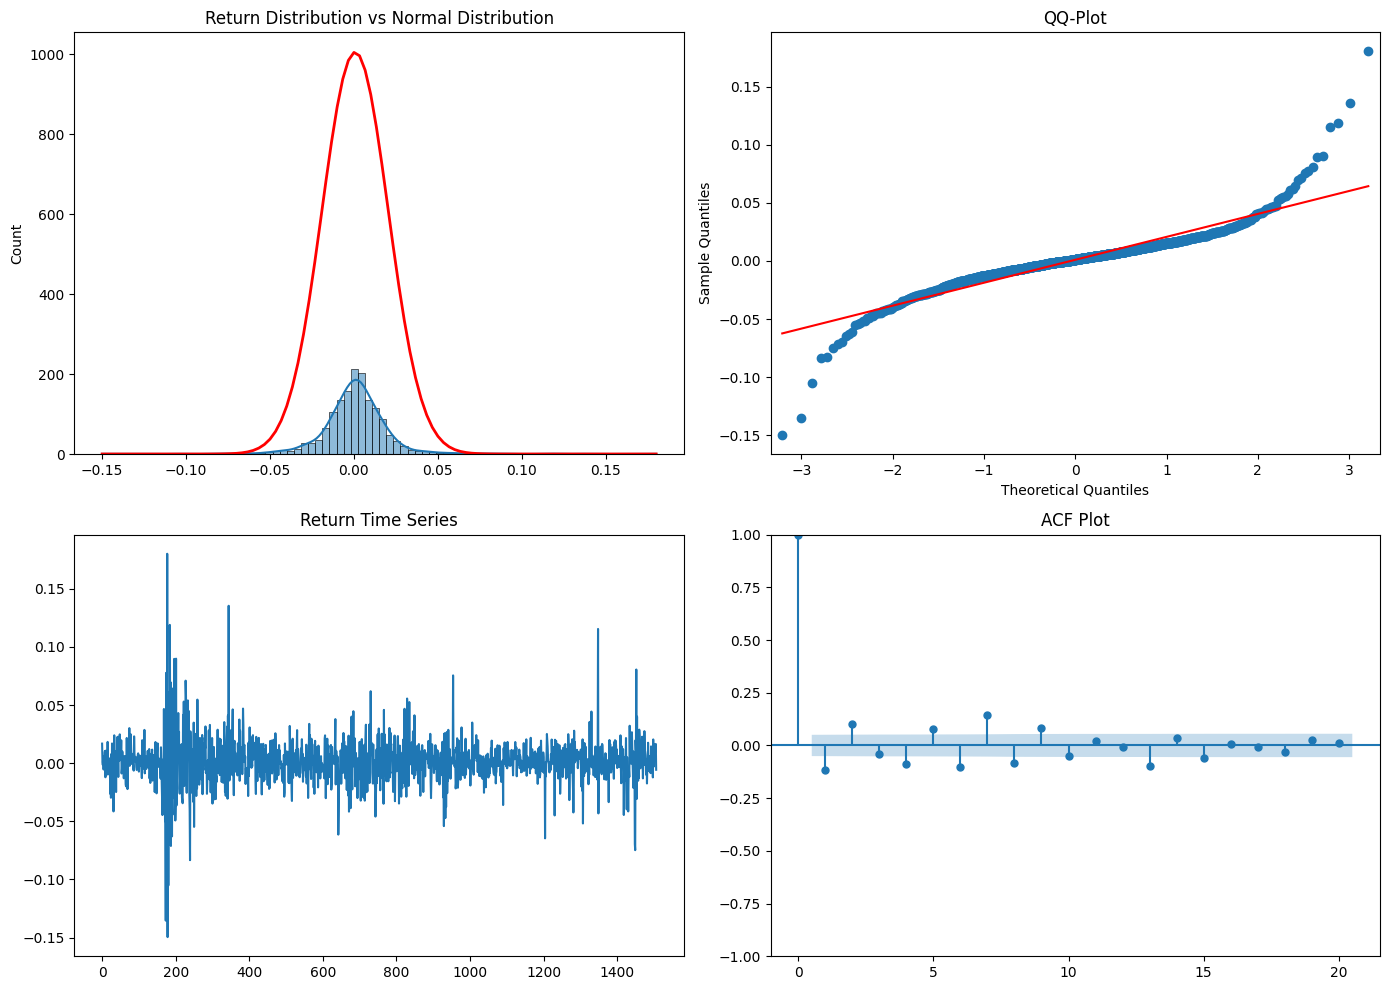

In [5]:
var = 'return'
results = return_statistics(data[var])
print_return_statistics(results)
plot_returns(data[var])

=== Stock Return Analysis ===
Mean: 0.000739
Variance: 0.000388
Standard Deviation: 0.019695
Autocorrelation (lag 1): -0.115767
Skewness: -0.073230
Excess Kurtosis: 12.570453

=== Normality Tests ===
Shapiro-Wilk Test: statistic=0.877445, p-value=0.000000
Jarque-Bera Test: statistic=9923.453124, p-value=0.000000

Interpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.


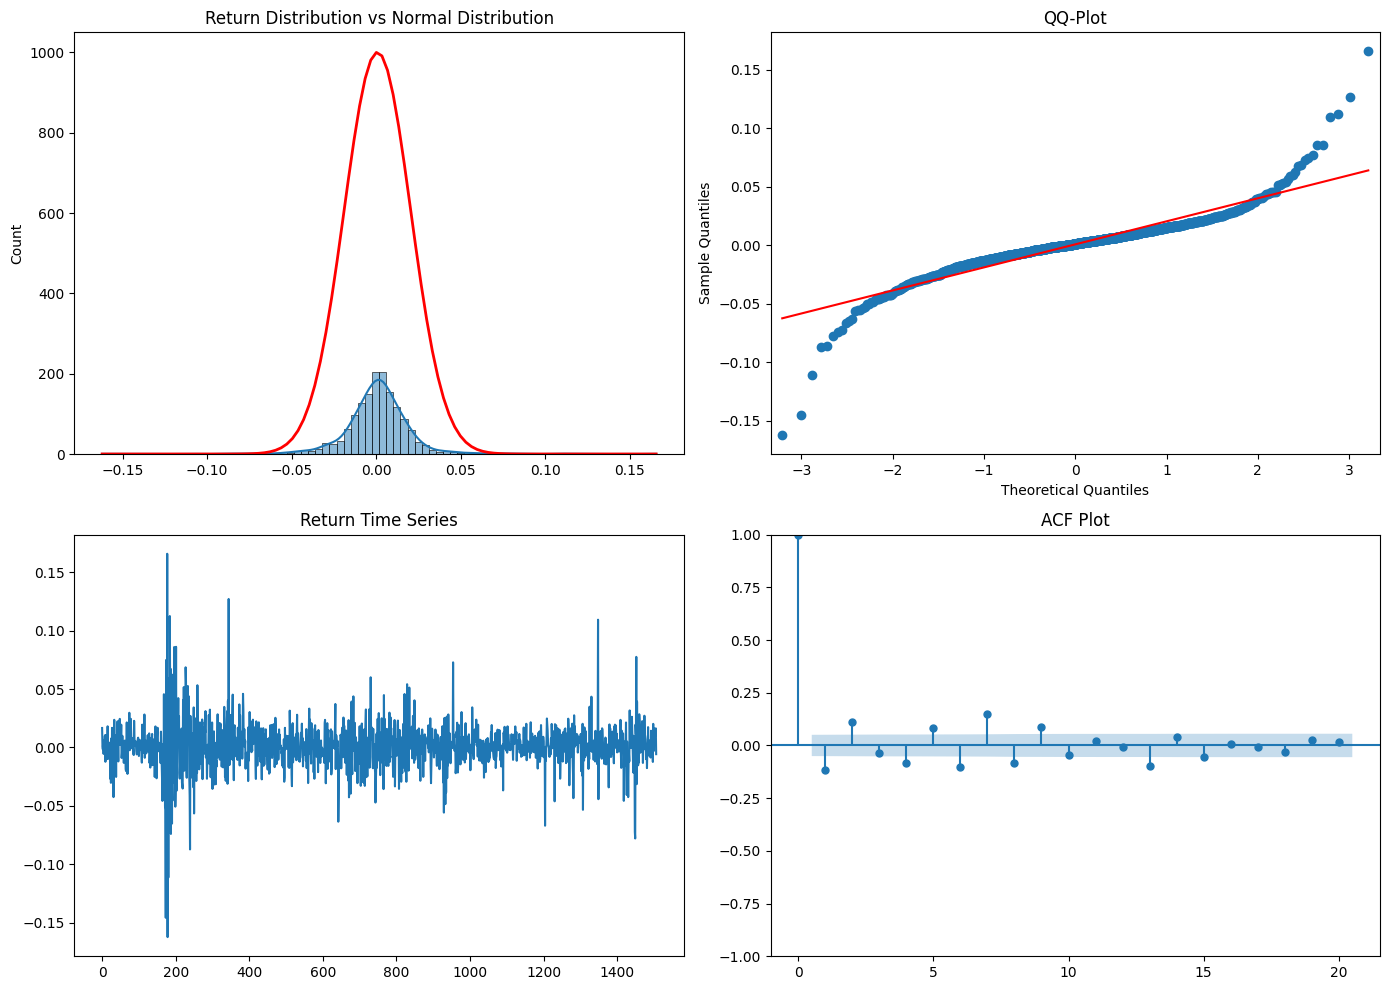

In [6]:
var = 'log_return'
results = return_statistics(data[var])
print_return_statistics(results)
plot_returns(data[var])

Both daily return and log(daily return) dont follow the normal distribution. We can see that log returns has lesser skew compared to the daily return, therfore log return is closer to normality

## Part II: Estimate CAPM Beta

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from datetime import datetime, timedelta

In [8]:
def get_monthly_returns(ticker, market_index, start_date=start_date, end_date=end_date):
    
    # Pull daily returns from yahoo finance
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    market_data = yf.download(market_index, start=start_date, end=end_date, progress=False)

    # Only keep data from Month Start
    stock_monthly = stock_data['Close'].resample('MS').last() 
    market_monthly = market_data['Close'].resample('MS').last()

    # Calculate Monthly Return
    stock_returns = stock_monthly.pct_change().dropna()
    market_returns = market_monthly.pct_change().dropna()

    returns_df = stock_returns.merge(market_returns, on='Date')
    return returns_df.reset_index()

In [10]:
def get_excess_returns(ticker, market_index, start_date=start_date, end_date=end_date):
    
    monthly_data = get_monthly_returns(ticker=ticker, market_index=market_index, start_date=start_date, end_date=end_date)
    
    tbill_data = pd.read_csv("./data/TB4WK.csv")
    tbill_data.columns = ['Date', 'T-Bill']
    tbill_data['Date'] = pd.to_datetime(tbill_data['Date'], format='%Y-%m-%d')
    tbill_data['T-Bill'] = tbill_data['T-Bill'] / 1200

    data = monthly_data.merge(tbill_data, on=['Date'], how='inner')
    data[f'{ticker} Excess Return'] = data[f'{ticker}'] - data['T-Bill']
    data[f'{market_index} Excess Return'] = data[f'{market_index}'] - data['T-Bill']

    cutoff_date = pd.to_datetime(end_date) -timedelta(days=365)
    train = data.loc[data['Date'] < cutoff_date]
    test = data.loc[data['Date'] >= cutoff_date]

    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")

    return train, test

In [11]:
def calculate_beta(data, ticker, market_index='SPY'):
    X = data[f'{market_index} Excess Return']
    y = data[f'{ticker} Excess Return']

    X = sm.add_constant(X)

    model = OLS(y, X).fit()
    alpha = model.params[0]
    beta = model.params[1]
    r_squared = model.rsquared

    beta_std_err = model.bse[1]

    t_stat = model.tvalues[1]
    p_value = model.pvalues[1]

    conf_int = model.conf_int().loc[f'{market_index} Excess Return']

    results = {
        'beta': beta,
        'alpha': alpha,
        'r_squared': r_squared,
        'beta_std_err': beta_std_err,
        't_stat': t_stat,
        'p_value': p_value,
        'conf_int_lower': conf_int[0],
        'conf_int_upper': conf_int[1],
        'model_summary': model.summary()
    }
    return model, results

In [12]:
def plot_regression(data, ticker, market_index='SPY', beta=None):
    plt.figure(figsize=(10,6))

    sns.regplot(
        x=f'{market_index} Excess Return',
        y=f'{ticker} Excess Return',
        data=data,
        scatter_kws={'alpha': 0.5},
        line_kws={'color' : 'red'}
        )
    
    beta_text = f" (β = {beta:.4f})" if beta is not None else ""
    plt.title(f'{ticker} vs {market_index} Monthly Returns {beta_text}', fontsize=14)
    plt.xlabel(f'{market_index} Returns', fontsize=12)
    plt.ylabel(f'{ticker} Returns', fontsize=12)

    plt.grid(True, alpha=0.3)

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [18]:
def abnormal_return_analysis(test, ticker, market_index, model):
    X = test[f'{market_index} Excess Return']
    X = sm.add_constant(X)
    y_pred = model.predict(X)
    y_actual = test[f'{ticker} Excess Return']

    abnormal_return = y_actual - y_pred
    print(f"{ticker} Mean Abnormal Return: {np.mean(abnormal_return):.4f}")
    print(f"{ticker} Std Dev Abnormal Return: {np.std(abnormal_return):.4f}")

    t_stat, p_value = stats.ttest_1samp(a=abnormal_return, popmean=0)

    if p_value < 0.05:
        print(f"p-value: {p_value:.4f} \nWe reject the null hypothesis; abnormal return (alpha) is statistically significant from zero")
    elif p_value >= 0.05:
        print(f"p-value: {p_value:.4f} \nWe fail to reject the null hypothesis; abnormal return (alpha) is not statistically significant from zero")

In [19]:
def capm_beta_estimation(ticker, market_index, start_date=start_date, end_date=end_date):
    train, test = get_excess_returns(ticker=ticker, market_index=market_index, start_date=start_date, end_date=end_date)
    model, results = calculate_beta(train, ticker, market_index)
    print(f"----- {ticker} -----")
    print(model.summary())
    plot_regression(train, ticker, market_index, beta=results['beta'])
    abnormal_return_analysis(test, ticker, market_index, model)

In [20]:
end_date = '2025-05-01'
start_date = '2019-04-30'

Train shape: (60, 6)
Test shape: (12, 6)
----- JPM -----
                            OLS Regression Results                            
Dep. Variable:      JPM Excess Return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     75.60
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           4.24e-12
Time:                        13:11:30   Log-Likelihood:                 92.035
No. Observations:                  60   AIC:                            -180.1
Df Residuals:                      58   BIC:                            -175.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

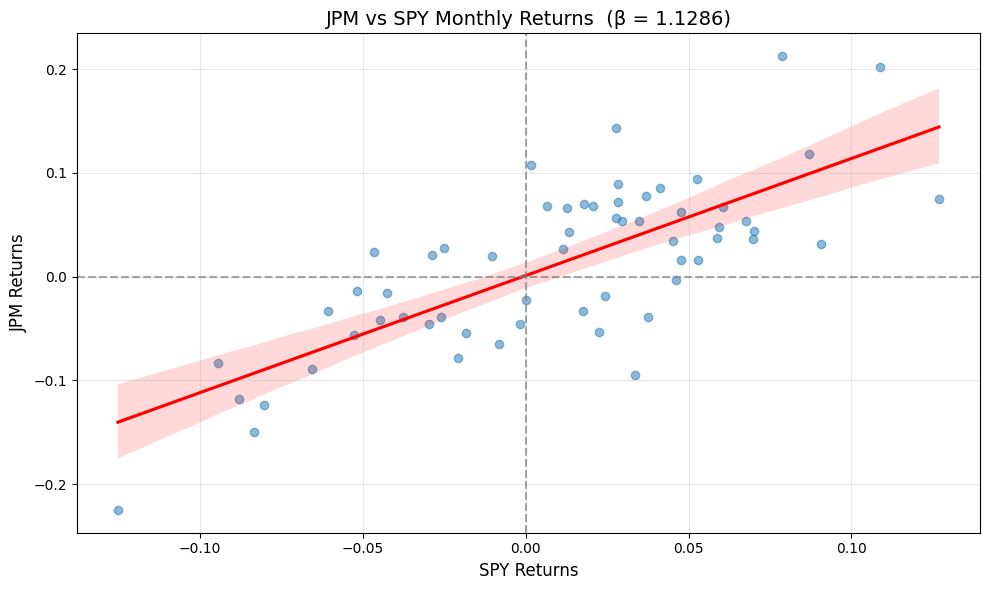

JPM Mean Abnormal Return: 0.0126
JPM Std Dev Abnormal Return: 0.0471
p-value: 0.3922 
We fail to reject the null hypothesis; abnormal return (alpha) is not statistically significant from zero


In [21]:
capm_beta_estimation(ticker='JPM', market_index='SPY', start_date=start_date, end_date=end_date)